test more estimators

In [1]:
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import numpy as np
import prince
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../data_lake/output/train_eng.pkl")
val = pd.read_pickle("../../data_lake/output/val_eng.pkl")

In [4]:
df = df.drop(columns=['card1', 'card2', 'card3','card5', 'addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','M4'])

In [5]:
val = val.drop(columns=['card1', 'card2', 'card3','card5', 'addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','M4'])

# 2.0 Training baseline

In [6]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [7]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [8]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [27]:
parameters = [
    {
        'model': (GradientBoostingClassifier(random_state=0,n_iter_no_change=25,warm_start=True,max_features='auto'),),
        'model__max_depth':(2,4),
        'model__n_estimators':(100,400),
        'model__learning_rate':(0.05,0.1)
    }, {
        'model': (RandomForestClassifier(),),
        'model__n_estimators': (100, 300),
    }, {
        'model': (MLPClassifier(solver='sdg',warm_start=True,early_stopping=True,activation='logistic'),)
    }, {
        'model': (HistGradientBoostingClassifier(),)
    }
]

In [28]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/anaconda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 673, in fit
    return self._fit(X, y, incremental=False)
  File "/anaconda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 357, in _fit
    self._validate_hyperparameters()
  File "/anaconda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 456, in _validate_hyperpara

GridSearchCV results...
Mean Train Scores: 
[0.74785116 0.78368824 0.80175212 0.8322327  0.76915414 0.79643699
 0.81915191 0.85565353 0.99887879 0.99871267        nan        nan]

Mean CV Scores: 
[0.74473521 0.77550669 0.78746744 0.80702598 0.76479257 0.78410297
 0.80042266 0.82060483 0.836054   0.84103712        nan        nan]

Best Parameters: 
{'model': RandomForestClassifier(n_estimators=300), 'model__n_estimators': 300}



# 3.0 Evaluation baseline

In [29]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [30]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [31]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8444846292947559
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     19976
         1.0       0.31      0.84      0.46      1659

    accuracy                           0.85     21635
   macro avg       0.65      0.85      0.68     21635
weighted avg       0.93      0.85      0.88     21635

TransactionAmt: 0.18274269857345343
ProductCD: 0.17811630215642507
card4: 0.1519504487873729
device_info_v4: 0.017537130051712917
id_33: 0.01321167437784866
browser_enc: 0.01252387830257399
num_transaction_per_time: 0.012180240018015136
id_30: 0.011509065703581933
id_32: 0.010259227958162687
DeviceType: 0.0036600405637943235
max_c: 0.003590364928715693
max_d: 0.0023943419771072475
card6: 0.0022664237377175572
P_emaildomain: 0.0022307681043061568
multi_transaction_per_time: 0.00021733971181120298
R_emaildomain

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d', 'num_transaction_per_time',
       'multi_transaction_per_t...
                           

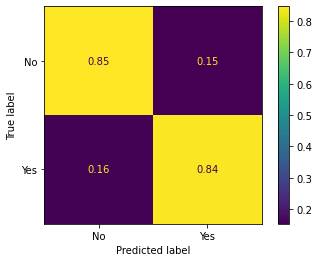

In [32]:
mlu.model_evaluation(m.base_estimator, X_val, y_val)